code: https://github.com/ritts97/Unsupervised-Face-Clustering

## Setup

In [1]:
import sys
import os
import dlib
import glob
import time

import cv2
import os

import matplotlib.pyplot as plt

from face_classifier import FaceClassifier

import random
import torch
import numpy as np

import calc
import icio
import postproc

from person_db import Person
from person_db import Face
from person_db import PersonDB

print(dlib.DLIB_USE_CUDA)
print(cv2.__version__)

True
4.5.5


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(79)

In [3]:
import face_recognition

def check_use_gpu(TARGET_IMG_PATH):
    image = face_recognition.load_image_file(TARGET_IMG_PATH)
    face_locations = face_recognition.face_locations(image,model='cnn')
    if len(face_locations) > 0:
        print('Using GPU')
    else:
        print('***Not using GPU***')

TARGET_IMG_PATH = "./test.jpg"
check_use_gpu(TARGET_IMG_PATH)

Using GPU


## Extract frame from video and save as images

In [4]:
video_paths = {
    0: "/opt/ml/project/test_videos/leejung_rain_before_14m.mp4",
    1: "/opt/ml/project/test_videos/giha_before_13m.mp4",
    2: "/opt/ml/project/test_videos/dongmin_before_15m.mp4",
    3: "/opt/ml/project/test_videos/KakaoTalk_20220526_162306287.mp4",
    4: "/opt/ml/project/test_videos/KakaoTalk_20220526_162432101.mp4",
    5: "/opt/ml/project/test_videos/KakaoTalk_20220526_162549989.mp4",
}

In [5]:
file_num = 0

filepath = video_paths[file_num]
video = cv2.VideoCapture(filepath)

assert video.isOpened(), f"Could not Open : {filepath}"

In [6]:
# 불러온 비디오 파일의 정보 출력
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 25562
width : 1280
height : 720
fps : 29.97002997002997


In [7]:
# 변수 설정
frame_batch_size = 16
capture_interval = 3 * int(round(fps)) # n초 간격 프레임 캡쳐
stop = 300 # 0 초과의 정수 지정 시 n 초 까지만 영상 실행
skip = 0 # 초반 n 초 skip
face_cnt = 150 # 몇 장의 인물 사진을 사용할 지
capture_cnt = 60
threshold = 0.36 # 같은 인물로 판단할 threshold -> 낮을수록 같은 인물로 판단하지 않음
ratio = 1.0 # resizing ratio인데, 건드리지 않는게 좋을 듯

In [8]:
result_dir = filepath[:-4] + '_test'
# pdb = PersonDB()
# pdb.load_db(result_dir)
# pdb.print_persons()

In [9]:
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print('Error: Creaing directory. ' + result_dir)

**dnn_superres 사용**
```
pip uninstall opencv-python
pip uninstall opencv-contrib-python
pip3 install opencv-contrib-python
```
- 코드 및 성능비교표: https://learnopencv.com/super-resolution-in-opencv/ 
- super resolution 모델들 & 다운로드 링크: https://github.com/opencv/opencv_contrib/blob/master/modules/dnn_superres/README.md

In [10]:
video = cv2.VideoCapture(filepath) 

# FaceClssifier 인스턴스 생성
fc = FaceClassifier(threshold, ratio, result_dir)

fingerprints = dict()

frames = []
frame_count = 0

running = True

total_start = time.time()
while running:
    ret, frame = video.read()

    if frame is None:
        break

    seconds = int(round(frame_count / fps, 3))
    # print(f"Running in {seconds} sec in video...")
    if seconds > stop > 0:
        break
    if seconds < skip:
        continue
    if frame_count % capture_interval == 0:
        # resize
        if frame.shape[0] > 1000:
            frame = cv2.resize(frame, None, fx=0.6, fy=0.6)
        frames.append(frame)
        
    if len(frames) == frame_batch_size:
        # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
        # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
        frame_fingerprints = fc.detect_faces(frames,frame_batch_size)
        if frame_fingerprints:
            fingerprints.update(frame_fingerprints)
            print('Face images: ', len(fingerprints))
            print()
        
        frames = []
        
    if len(fingerprints) >= 150:
        break
    
    frame_count += 1



# restore SIGINT (^C) handler
running = False
video.release()
print()

# pdb.save_db(result_dir)
# pdb.print_persons()

total_end = time.time()
print('Inference time: ',total_end-total_start)
print("Captured frames : ", frame_count)

image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-0.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-1.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-2.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-3.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-4.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-5.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-6.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-7.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-8.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_test/202206

In [11]:
filepath = video_paths[file_num]
result_dir = filepath[:-4] + '_test'

#images : #clusters
3 : 1
5 : 1
27 : 1
29 : 1
#images in clusters total:  64
cluster dir: /opt/ml/project/test_videos/leejung_rain_before_14m_test/imagecluster/clusters
/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124048.507-8.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124054.173-2.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-3.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-18.png
/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-23.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-0.png


/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124056.858-13.png
/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124048.507-9.png

/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-6.png
/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124056.858-11.pn

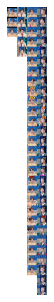

In [12]:
# 클러스터링(fingerprints) 후 결과 출력
clusters = calc.cluster(fingerprints, sim=0.62, method='single', min_csize=3) # 높일수록 엄격하게
# clusters = calc.cluster({filename: encoding for filename, (encoding, face, cloth) in fingerprints.items()}, sim=0.62, method='single', min_csize=3)

postproc.make_links(clusters, os.path.join(result_dir, 'imagecluster/clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_cluster.png'))
postproc.plt.show()

**pseudo code**

def merge_clusters(cluster_dir):
    cluster_fingerprints = []

    for cluster_num_dir in cluster_dir:
        for cluster in cluster_num_dir:
            cluster_fingerprint = np.zeros(shape=(256,))
            i = 0
            for person_image in cluster:
                cluster_fingerprint += fingerprint[person_image]
                i += 1
            assert i > 0, cluster is empty!
            cluster_fingerprint /= i
            cluster_fingerprints.append([cluster, cluster_fingerprint])

    saved_clusters = []
    merged_clusters = []

    for i in range(len(cluster_fingerprints)-1):
        if cluster_fingerprints[i][0] in merged_clusters:
            continue
        else:
            saved_clusters.append(cluster_fingerprints[i][0])
        for j in range(i+1, len(cluster_fingerprints)):
            norm = np.norm(cluster_fingerprints[i][1]-cluster_fingerprints[j][1])
            if norm < THRESHOLD:
                merged_clusters.append(cluster_fingerprints[j][0])

    return saved_clusters, merged_clusters



In [13]:
# for i in range(len(fingerprints)):
#     print(list(fingerprints.items())[i][1].shape)
# '/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_test/20220531_023109.767-58.png'
# print(len(list(fingerprints.values())[0]))

In [14]:
def merge_clusters(cluster_dict, fingerprints, iteration=1, FACE_THRESHOLD_HARD=0.18, CLOTH_THRESHOLD_HARD=0.12, FACE_THRESHOLD_SOFT=0.19, CLOTH_THRESHOLD_SOFT=0.15) -> dict:
    '''
    parameters:
        clusters: calc.cluster() 의 return 값 (dict / key=cluster_size(int), value=clusters(2d-array))
        fingerprints: feature vector dictionary (key=filepath, value=feature vector)
        iteration: merge 반복 횟수
        FACE_THRESHOLD_HARD
        CLOTH_THRESHOLD_HARD
        FACE_THRESHOLD_SOFT
        CLOTH_THRESHOLD_SOFT
    return:
        merged_clusters: calc.cluster() 의 return 값과 동일한 형태 (dict / key=cluster_size(int), value=clusters(2d-array))
    '''

    for _ in range(iteration):
        cluster_list = sorted([[key, value] for key, value in cluster_dict.items()], key=lambda x:x[0], reverse=True)
        cluster_fingerprints = [] # [(face, cloth), ...]
        cluster_cnt = 0

        for cluster_with_num in cluster_list:
            num, clusters = cluster_with_num
            for idx, cluster in enumerate(clusters):
                cluster_face_fingerprint = np.zeros((128,))
                cluster_cloth_fingerprint = np.zeros((128,))
                i = 0
                for person in cluster:
                    encoding = fingerprints[person]
                    face, cloth = encoding[:128], encoding[128:]
                    cluster_face_fingerprint += face
                    cluster_cloth_fingerprint += cloth
                    i += 1
                assert i > 0, 'cluster is empty!'
                cluster_face_fingerprint /= i
                cluster_cloth_fingerprint /= i

                cluster_fingerprints.append([(num, idx), (cluster_face_fingerprint, cluster_cloth_fingerprint)])
                cluster_cnt += 1

        merged = []
        merged_clusters = dict()

        for i in range(cluster_cnt):
            if cluster_fingerprints[i][0] in merged:
                continue
            big_num, big_idx = cluster_fingerprints[i][0]
            person_list = cluster_dict[big_num][big_idx]
            merged_num = big_num
            for j in range(i+1, cluster_cnt):
                cluster_face_norm = round(np.linalg.norm(cluster_fingerprints[i][1][0] - cluster_fingerprints[j][1][0]),3)
                cluster_cloth_norm = round(np.linalg.norm(cluster_fingerprints[i][1][1] - cluster_fingerprints[j][1][1]),3)
                if cluster_face_norm < FACE_THRESHOLD_HARD or cluster_cloth_norm < CLOTH_THRESHOLD_HARD or \
                    (cluster_face_norm < FACE_THRESHOLD_SOFT and cluster_cloth_norm < CLOTH_THRESHOLD_SOFT):
                    small_num, small_idx = cluster_fingerprints[j][0]
                    merged_num += small_num
                    person_list += cluster_dict[small_num][small_idx]
                    merged.append(cluster_fingerprints[j][0])
                    
            merged_clusters[merged_num] = merged_clusters.get(merged_num, [])
            merged_clusters[merged_num].append(person_list)

        cluster_dict = merged_clusters

    return merged_clusters

cluster dir: /opt/ml/project/test_videos/leejung_rain_before_14m_test/imagecluster/merged_clusters
/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-18.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124054.173-2.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124048.507-8.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124037.772-3.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-0.png

/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124045.845-23.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124056.858-13.png
/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124048.507-9.png



/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124056.858-19.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_124048.507-6.png/opt/ml/project/test_videos/leejung_rain_before_14m_test/20220601_1240

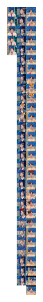

In [15]:
FACE_THRESHOLD_HARD = 0.18
CLOTH_THRESHOLD_HARD = 0.12
FACE_THRESHOLD_SOFT = 0.19
CLOTH_THRESHOLD_SOFT = 0.15
merged_clusters = merge_clusters(clusters, fingerprints, 1, FACE_THRESHOLD_HARD, CLOTH_THRESHOLD_HARD, FACE_THRESHOLD_SOFT, CLOTH_THRESHOLD_SOFT)

postproc.make_links(merged_clusters, os.path.join(result_dir, 'imagecluster/merged_clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(merged_clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_merged_cluster.png'))
postproc.plt.show()